In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

Setting environment for Precision WorkStation


No vtk
No vtk/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Collect all image names (before rotation, before thumbnail generation)

In [3]:
stack = 'CHATM3'

In [4]:
# The set of dirs where we should search for image files.
raw_data_dirs = \
{('Ntb', 'raw'): '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_Ntb',
('CHAT', 'raw'): '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_CHAT',
('AF', 'raw'): '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_AF',
('Ntb', 'thumbnail'): None}

# image_name_to_metainfo_mapping = '%(brain_id)s_slide%(slide_num)d_%(year)s_%(month)s_%(day)s_S%(scene_index)d'

image_name_to_metainfo_re_pattern = '(.*?)_slide([0-9]*?)_([0-9]*?)_([0-9]*?)_([0-9]*?)-S([0-9])'
# image_name_to_metainfo_re_semantics = ['brain_id', 'slide_num', 'year', 'month', 'day', 'scene_index']

# g = re.search(image_name_to_metainfo_re_pattern, img_name)
# groups = g.groups()
# dict(zip(image_name_to_metainfo_re_semantics, groups))

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{('Ntb', 'raw'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_Ntb/(.*)_.*?_.*?.tif',
 ('CHAT', 'raw'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_CHAT/(.*)_.*?_.*?.tif', 
 ('AF', 'raw'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_AF/(.*)_.*?_.*?.tif', 
}

In [5]:
image_names_all_data_dirs_flattened = set([])
image_names_all_data_dirs = {}
for vr, data_dir in raw_data_dirs.iteritems():
    if data_dir is None: continue
    image_names = set([])
    if vr in input_image_filename_to_imagename_re_pattern_mapping:
        for fn in os.listdir(data_dir):
            g = re.search(input_image_filename_to_imagename_re_pattern_mapping[vr], os.path.join(data_dir, fn))
            img_name = g.groups()[0]
            image_names.add(img_name)
            image_names_all_data_dirs_flattened.add(img_name)
    image_names_all_data_dirs[vr] = image_names
    
    
# Make sure the every image has all three channels.
for vr, img_names in image_names_all_data_dirs.iteritems():
    print vr, 'missing:' 
    print image_names_all_data_dirs_flattened - img_names
    print 

('CHAT', 'raw') missing:
set([])

('Ntb', 'raw') missing:
set([])

('AF', 'raw') missing:
set([])



In [6]:
print len(image_names_all_data_dirs_flattened), 'images are found.'

293 images are found.


In [7]:
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
valid_filenames = sorted(list(image_names_all_data_dirs_flattened), key=lambda n: int(n.split('_')[1][5:]))
# Do not need sorted list at this stage. Simply sort by slide number for ease of examination.

# Specify paths of raw data (original orientation)

These are data that have not been rotated to standard orientation.
so they are not stored into the standard location.

In [8]:
orig_orientation_image_name_to_filepath_mappings = {
    ('Ntb', 'raw'): \
     '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_Ntb/%(image_name)s_lossless_Ntb.tif',
     ('Ntb', 'thumbnail'): \
     '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_thumbnail_Ntb/%(image_name)s_thumbnail_Ntb.tif',
     ('CHAT', 'raw'): \
     '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_raw_CHAT/%(image_name)s_lossless_CHAT.tif',  
    ('NtbNormalized', 'thumbnail'): \
 '/media/yuncong/BethandHannah_External2/CHATM3/CHATM3_thumbnail_NtbNormalized/%(image_name)s_thumbnail_NtbNormalized.tif'
}

# Generate thumbnails (original orientation)

In [ ]:
thumbnail_downscale_factor = 32

In [ ]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = orig_orientation_image_name_to_filepath_mappings[('Ntb', 'raw')] % {'image_name': img_name}
    out_fp = orig_orientation_image_name_to_filepath_mappings[('Ntb', 'thumbnail')] % {'image_name': img_name}
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

    # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
#     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Contrast stretch thumbnails (original orientation)

In [ ]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = orig_orientation_image_name_to_filepath_mappings[('Ntb', 'thumbnail')] % {'image_name': img_name}
    out_fp = orig_orientation_image_name_to_filepath_mappings[('NtbNormalized', 'thumbnail')] % {'image_name': img_name}
    create_parent_dir_if_not_exists(out_fp)
        
    cmd = """convert "%(in_fp)s" -normalize -depth 8 "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp}
    execute_command(cmd)
    
    sys.stderr.write("Intensity normalize: %.2f seconds." % (time.time() - t))

# Rotate to standard orientation
Top is dorsal, left is anterior

In [9]:
if stack == 'CHATM2':
    image_filename_to_orientation_mapping = \
    {
        img_name: 'top_posterior_left_ventral' for img_name in valid_filenames
    }
elif stack == 'CHATM3':
    image_filename_to_orientation_mapping = {}
    for img_name in valid_filenames:
        if img_name == 'CHATM3_slide07_2018_02_18-S1':
            image_filename_to_orientation_mapping[img_name] = 'top_posterior_left_ventral'
        else:
            image_filename_to_orientation_mapping[img_name] = 'top_anterior_left_dorsal'

In [41]:
# for img_name in valid_filenames:

#     for rule_identifier in [('NtbNormalized', 'thumbnail')]:
        
#         version, resol = rule_identifier

#         t = time.time()

#         in_fp = orig_orientation_image_name_to_filepath_mappings[rule_identifier] % {'image_name': img_name}

#         out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
#         create_parent_dir_if_not_exists(out_fp)

#         # Reference: http://www.imagemagick.org/Usage/warping/#flip
#         orientation = image_filename_to_orientation_mapping[img_name]

#         if orientation == 'top_anterior_left_dorsal':
#             rotate = '-transpose'
#         elif orientation == 'top_anterior_left_ventral':
#             rotate = '-rotate 90'
#         elif orientation == 'top_posterior_left_ventral':
#             rotate = '-transverse'
#         else:
#             rotate = ''

#         if rotate == '':
#             execute_command('rm -f %(out_fp)s; ln -s %(in_fp)s %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp})
#         else:
#             cmd1 = """convert "%(in_fp)s" %(rotate)s "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp, 'rotate': rotate}
#             execute_command(cmd1)

#         sys.stderr.write("Rotate: %.2f seconds.\n" % (time.time() - t))

In [22]:
for img_name in valid_filenames[182:]:

    for rule_identifier in [('CHAT', 'raw')]:
#     for rule_identifier in [('Ntb', 'raw')]:
#     for rule_identifier in [('NtbNormalized', 'thumbnail')]:

        version, resol = rule_identifier

        t = time.time()

        in_fp = orig_orientation_image_name_to_filepath_mappings[rule_identifier] % {'image_name': img_name}

        img = imread(in_fp)
        
        out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
        create_parent_dir_if_not_exists(out_fp)

        # Reference: http://www.imagemagick.org/Usage/warping/#flip
        orientation = image_filename_to_orientation_mapping[img_name]

        if orientation == 'top_anterior_left_dorsal':
            img_rotated = img.T
        elif orientation == 'top_anterior_left_ventral':
            img_rotated = img.T[::-1]
        elif orientation == 'top_posterior_left_ventral':
            img_rotated = img[::-1, ::-1].T
        else:
            img_rotated = img
        
        imsave(out_fp, img_rotated)
    
        sys.stderr.write("Rotate: %.2f seconds.\n" % (time.time() - t)) # 10s / section
        # skimage read and manipulate in memory is faster than imagemagick
        
        del img, img_rotated

Rotate: 129.82 seconds.
Rotate: 118.05 seconds.
Rotate: 187.44 seconds.
Rotate: 194.26 seconds.
Rotate: 181.14 seconds.
Rotate: 188.48 seconds.
Rotate: 175.37 seconds.
Rotate: 172.35 seconds.
Rotate: 176.11 seconds.
Rotate: 173.95 seconds.
Rotate: 183.86 seconds.
Rotate: 179.25 seconds.
Rotate: 204.40 seconds.
Rotate: 172.04 seconds.
Rotate: 204.24 seconds.
Rotate: 209.91 seconds.
Rotate: 201.79 seconds.
Rotate: 197.41 seconds.
Rotate: 184.23 seconds.
Rotate: 146.40 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_raw_CHAT/CHATM3_slide73_2018_01_26-S1_raw_CHAT.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rotate: 157.25 seconds.
Rotate: 172.53 seconds.
Rotate: 204.32 seconds.
Rotate: 253.87 seconds.
Rotate: 202.29 seconds.
Rotate: 196.91 seconds.
Rotate: 196.10 seconds.
Rotate: 194.43 seconds.
Rotate: 198.92 seconds.
Rotate: 218.08 seconds.
Rotate: 201.49 second

# Check image shape (after correcting orientation)

In [23]:
rule_identifier = ('Ntb', 'raw')
# rule_identifier = ('NtbNormalized', 'thumbnail')
version, resol = rule_identifier

for img_name in valid_filenames:
    fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=resol, version=version, fn=img_name)
    width, height = identify_shape(fp)
#     print img_name, (width, height)
    assert width > height, "image %s, width smaller than height" % img_name

# Sort images

In [24]:
# filenames_to_sections, _ = DataManager.load_sorted_filenames(stack=stack)

# Align, compute transform between adjacent sections

In [25]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack, redownload=True) 
# Note that this could be the human-corrected version, in which case the transforms may not exist.
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
print len(valid_filenames), 'valid filenames'

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_sorted_filenames.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_sorted_filenames.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_sorted_filenames.txt"
0
293 valid filenames


In [29]:
tb_fmt = 'tif'

In [26]:
version = 'NtbNormalized'

In [27]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')    
output_dir = create_if_not_exists(os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_elastix_output'))

In [ ]:
! rm -fr "{output_dir}"

In [30]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \"%(output_dir)s\" \'%%(kwargs_str)s\' %(fmt)s " % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt,
                },
                kwargs_list=[{'prev_fn': valid_filenames[i-1] + '_thumbnail_' + version, 
                              'curr_fn': valid_filenames[i] + '_thumbnail_' + version,
                             'prev_sn': valid_filenames[i-1] ,
                             'curr_sn': valid_filenames[i] } 
                             for i in range(1, len(valid_filenames))],
                argument_type='list',
                jobs_per_node=8,
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 2252 seconds full stack

Align...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 2252.02874422 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [31]:
upload_to_s3(output_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_elastix_output" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_elastix_output"
0


# Check alignment metrics

In [32]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
#     if stack == 'ChatCryoJane201710':
#         prev_fn = valid_filenames[i-1] + '-Ntb'
#         curr_fn = valid_filenames[i] + '-Ntb'
#     else:
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]

    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        if g is None:
            print i
        final_metric[i] = float(g.groups()[0])

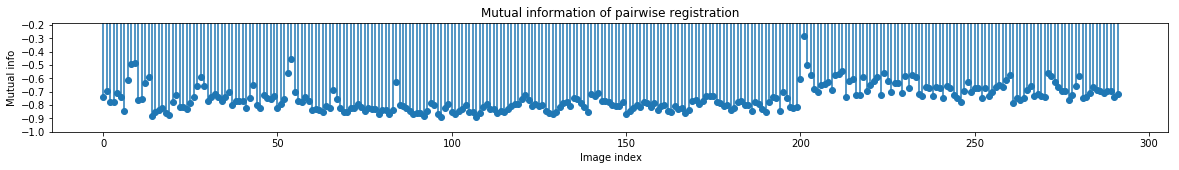

In [33]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

In [34]:
problematic_moving_indices = np.where(abs(metric_arr) < .6)[0] + 1

print 'Pairs to check (moving, fixed):'
[(valid_filenames[moving_ind], valid_filenames[moving_ind-1]) for moving_ind in problematic_moving_indices]

Pairs to check (moving, fixed):


[('CHATM3_slide04_2018_02_17-S2', 'CHATM3_slide03_2018_02_18-S2'),
 ('CHATM3_slide03_2018_02_18-S3', 'CHATM3_slide04_2018_02_17-S2'),
 ('CHATM3_slide05_2018_02_17-S2', 'CHATM3_slide06_2018_02_17-S1'),
 ('CHATM3_slide12_2018_02_17-S1', 'CHATM3_slide11_2018_02_17-S1'),
 ('CHATM3_slide20_2018_02_17-S3', 'CHATM3_slide19_2018_02_18-S3'),
 ('CHATM3_slide21_2018_02_17-S1', 'CHATM3_slide20_2018_02_17-S3'),
 ('CHATM3_slide73_2018_01_26-S2', 'CHATM3_slide73_2018_01_26-S1'),
 ('CHATM3_slide73_2018_01_26-S3', 'CHATM3_slide73_2018_01_26-S2'),
 ('CHATM3_slide75_2018_01_26-S1', 'CHATM3_slide73_2018_01_26-S3'),
 ('CHATM3_slide79_2018_01_26-S2', 'CHATM3_slide79_2018_01_26-S1'),
 ('CHATM3_slide79_2018_01_26-S3', 'CHATM3_slide79_2018_01_26-S2'),
 ('CHATM3_slide83_2018_01_26-S1', 'CHATM3_slide79_2018_01_26-S3'),
 ('CHATM3_slide87_2018_01_26-S2', 'CHATM3_slide87_2018_01_26-S1'),
 ('CHATM3_slide91_2018_01_26-S2', 'CHATM3_slide89_2018_01_26-S3'),
 ('CHATM3_slide93_2018_01_26-S1', 'CHATM3_slide91_2018_01_26-S

In [35]:
q = np.argmin(np.abs(final_metric.values()))
print 'worst pair (moving, fixed):', valid_filenames[q], valid_filenames[q-1]

worst pair (moving, fixed): CHATM3_slide73_2018_01_26-S1 CHATM3_slide72_2018_02_19-S3


# Check and correct alignments

# Compose alignments

In [36]:
download_from_s3(os.path.join('CSHL_data_processed', stack, stack + '_custom_transforms'), 
                 is_dir=True, local_root=DATA_ROOTDIR)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_custom_transforms" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_custom_transforms" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_custom_transforms"
0


In [37]:
download_from_s3(os.path.join('CSHL_data_processed', stack, stack + '_anchor.txt'), 
                     is_dir=False,
                    local_root=DATA_ROOTDIR)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_anchor.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_anchor.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_anchor.txt"
0


In [38]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)
anchor_idx = valid_filenames.index(anchor_fn)
print 'anchor_idx =', anchor_idx

anchor_idx = 207


In [39]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                         dict(stack=stack, anchor_fn=anchor_fn))

In [40]:
! rm -f "{output_fp}"

In [41]:
t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \'%%(kwargs_str)s\' %(anchor_idx)d \"%(output_fp)s\"" % \
            {'stack': stack,
            'script': script,
            'input_dir': input_dir,
            'anchor_idx': anchor_idx,
            'output_fp': output_fp},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list',
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds

Composing transform...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 2.69102907181 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [42]:
upload_to_s3(output_fp)

aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl"
0


# Transform

In [43]:
transforms_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                                dict(stack=stack, anchor_fn=anchor_fn))
download_from_s3(transforms_fp, redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_transformsTo_CHATM3_slide77_2018_01_26-S1.pkl"
0


In [44]:
pad_bg_color = 'black'

In [46]:
prep_id = 1

In [47]:
version = 'NtbNormalized'

In [48]:
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')
out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, resol='thumbnail', version=version)
print 'out_dir:', out_dir
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

out_dir: /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized


In [49]:
! rm -rf {out_dir}

In [50]:
t = time.time()
print 'Warping...'

transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, anchor_fn=anchor_fn)

if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': os.path.join(input_dir, \
                                                        fn + '_thumbnail_' + version + '.' + tb_fmt \
                                              if version is not None \
                                              else fn + '.' + tb_fmt),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol='thumbnail'),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)
else:
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': os.path.join(input_dir, \
                                                        fn + '_thumbnail_' + version + '.' + tb_fmt \
                                              if version is not None \
                                              else fn + '.' + tb_fmt),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol='thumbnail'),
                                 }
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)

# wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 300 seconds.

Warping...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 80.5162379742 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [51]:
upload_to_s3(out_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized"
0


# Check whether given image order is correct

In [52]:
out_dir = '/tmp/tmp_sorted_images'
execute_command('rm -r ' + out_dir)

rule_identifier = ('NtbNormalized', 'thumbnail')

version, resol = rule_identifier

for img_name, section_index in filenames_to_sections.iteritems():   
    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=1, resol=resol, version=version, fn=img_name)
    out_fp = os.path.join(out_dir, '%04d.tif' % section_index)
    create_parent_dir_if_not_exists(out_fp)
#     print in_fp, out_fp
    execute_command('ln -s %(in_fp)s %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp})
#     upload_to_s3(out_fp)

rm -r /tmp/tmp_sorted_images
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide66_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0192.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide50_2018_02_18-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0144.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide50_2018_02_18-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0146.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide50_2018_02_18-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0148.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide28_2018_02_17-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_im

0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide115_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0343.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide115_2018_01_26-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0341.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide60_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0174.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide71_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0209.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide71_2018_02_19-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0211.tif
0
ln -s /medi

ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide75_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0223.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide47_2018_02_18-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0137.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide119_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0355.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide65_2018_02_19-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0195.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide34_2018_02_17-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0100.tif
0
ln -s /media/y

ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide63_2018_02_19-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0187.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide14_2018_02_18-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0038.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide62_2018_02_19-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0182.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide62_2018_02_19-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0184.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide14_2018_02_18-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0040.tif
0
ln -s /media/yu

0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide17_2018_02_17-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0047.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide69_2018_02_19-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0207.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide27_2018_02_17-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0077.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide69_2018_02_19-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0203.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide79_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0235.tif
0
ln -s /media/

0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide107_2018_01_26-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0319.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide107_2018_01_26-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0321.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide107_2018_01_26-S1_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0317.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide109_2018_01_26-S3_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0327.tif
0
ln -s /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_prep1_thumbnail_NtbNormalized/CHATM3_slide35_2018_02_17-S2_prep1_thumbnail_NtbNormalized.tif /tmp/tmp_sorted_images/0103.tif
0
ln -s /me